# This notebook is for analysis of outliers

#### 0 - Load in necessary modules and begin Spark

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/24 11:10:43 WARN Utils: Your hostname, LAPTOP-MMSL4U2D resolves to a loopback address: 127.0.1.1; using 172.20.165.105 instead (on interface eth0)
24/09/24 11:10:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 11:10:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 1. Impute null values

In [ ]:
# Load in merged dataset
trans_final_sdf = spark.read.parquet('../data/merged/transactions_POA_PI.parquet')
trans_final_sdf.printSchema()

In [5]:
# Count the number of null values in each column
null_counts = trans_final_sdf.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in trans_final_sdf.columns])
null_counts.show()

+-------+------------+------------+--------+--------------+-------------+------+-----------+-----+--------+------+-----------------------------+--------------------------+-----------------------------+--------------------------+-------------+-------------+--------+----------------+----------------------+----------------+------------+--------------------+--------------------------+--------------------+
|user_id|merchant_abn|dollar_value|order_id|order_datetime|merchant_name|  tags|consumer_id|state|postcode|gender|consumer_fraud_order_datetime|consumer_fraud_probability|merchant_fraud_order_datetime|merchant_fraud_probability|LOCALITY_NAME|list_SA2_CODE|list_ERP|list_num_earners|list_total_income_($M)|list_mean_income|postcode_ERP|postcode_num_earners|postcode_total_income_($M)|postcode_mean_income|
+-------+------------+------------+--------+--------------+-------------+------+-----------+-----+--------+------+-----------------------------+--------------------------+-------------------

In [6]:
# impute null values as 0 in the fraud probability rows 
# (as these transactions are assumed to be not fraudulent)
trans_final_sdf = trans_final_sdf.fillna(
    {'consumer_fraud_probability': 0, 'merchant_fraud_probability': 0}
)

In [7]:
# Remove rows with null "merchant_name" (and therefore tags)
trans_final_sdf = trans_final_sdf.filter(trans_final_sdf.merchant_name.isNotNull())

# Remove 'consumer_fraud_order_datetime' and 'merchant_fraud_order_datetime' columns, given that 
trans_final_sdf = trans_final_sdf.drop("consumer_fraud_order_datetime", "merchant_fraud_order_datetime")

trans_final_sdf.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_fraud_probability: double (nullable = false)
 |-- merchant_fraud_probability: double (nullable = false)
 |-- LOCALITY_NAME: string (nullable = true)
 |-- list_SA2_CODE: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- list_ERP: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- list_num_earners: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- list_total_income_($M): array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- list

#### 2. Conduct outlier analysis

In [8]:
# Cast fraud probability columns to double
trans_final_sdf = trans_final_sdf.withColumn("merchant_fraud_probability",\
                                            F.col("merchant_fraud_probability").cast("double"))
trans_final_sdf = trans_final_sdf.withColumn("consumer_fraud_probability",\
                                            F.col("consumer_fraud_probability").cast("double"))

# Calculate the maximum and minimum values of fraud probabilities
fraud_stats = trans_final_sdf.agg(
    F.max("merchant_fraud_probability").alias("max_merchant_fraud_probability"),
    F.min("merchant_fraud_probability").alias("min_merchant_fraud_probability"),
    F.max("consumer_fraud_probability").alias("max_consumer_fraud_probability"),
    F.min("consumer_fraud_probability").alias("min_consumer_fraud_probability")
)

# Show the results
fraud_stats.show()

+------------------------------+------------------------------+------------------------------+------------------------------+
|max_merchant_fraud_probability|min_merchant_fraud_probability|max_consumer_fraud_probability|min_consumer_fraud_probability|
+------------------------------+------------------------------+------------------------------+------------------------------+
|             91.09606847149965|                           0.0|              97.6298077657765|                           0.0|
+------------------------------+------------------------------+------------------------------+------------------------------+



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

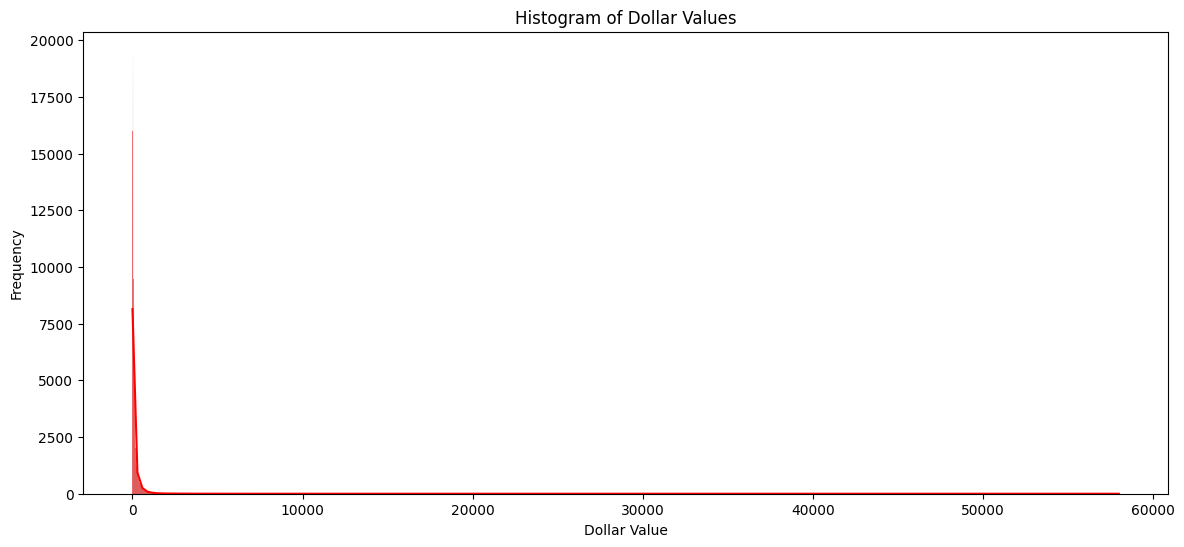

In [10]:
# Analyse the distribution of the dollar values across all transactions  

transactions_df_sampled = trans_final_sdf.sample(fraction=0.05, seed=42)

transactions_df_pd = transactions_df_sampled.select("dollar_value").toPandas()

plt.figure(figsize=(14, 6))

sns.histplot(transactions_df_pd['dollar_value'], color='red', kde=True)
plt.title('Histogram of Dollar Values')
plt.xlabel('Dollar Value')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Find high-value transactions
high_value_count = trans_final_sdf.filter(trans_final_sdf.dollar_value > 40000).count()
print(f"Number of transactions with dollar value > $40000: {high_value_count}")
trans_final_sdf.filter(trans_final_sdf.dollar_value > 40000).show(100)

Number of transactions with dollar value > $40000: 76


+-------+------------+------------------+--------------------+--------------+--------------------+--------------------+-----------+-----+--------+-----------+--------------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+------------+--------------------+--------------------------+--------------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|       merchant_name|                tags|consumer_id|state|postcode|     gender|consumer_fraud_probability|merchant_fraud_probability|       LOCALITY_NAME|       list_SA2_CODE|            list_ERP|    list_num_earners|list_total_income_($M)|    list_mean_income|postcode_ERP|postcode_num_earners|postcode_total_income_($M)|postcode_mean_income|
+-------+------------+------------------+--------------------+--------------+--------------------+--------------------+-----------+-----+--------+--------

In [12]:
# Filter the rows where dollar_value > 10000 and tags do not include specific strings
filtered_df = trans_final_sdf.filter(
    (trans_final_sdf.dollar_value > 10000) &
    (~trans_final_sdf.tags.rlike("(?i)jewelry")) &   # Case-insensitive match
    (~trans_final_sdf.tags.rlike("(?i)antique shops")) &
    (~trans_final_sdf.tags.rlike("(?i)art dealers"))
)

# Show the filtered entries
filtered_df.show()

# Potentially, could consider removing large entries as these are bad for a BNPL firm 
# (we take on much more credit risk). 
# However, all these entry values seem reasonable given the types of firms that are mentioned.

+-------+------------+------------------+--------------------+--------------+--------------------+--------------------+-----------+-----+--------+-----------+--------------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+------------+--------------------+--------------------------+--------------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|       merchant_name|                tags|consumer_id|state|postcode|     gender|consumer_fraud_probability|merchant_fraud_probability|       LOCALITY_NAME|       list_SA2_CODE|            list_ERP|    list_num_earners|list_total_income_($M)|    list_mean_income|postcode_ERP|postcode_num_earners|postcode_total_income_($M)|postcode_mean_income|
+-------+------------+------------------+--------------------+--------------+--------------------+--------------------+-----------+-----+--------+--------

In [13]:
# add is_fraud flag for entries with fraud_probability > 90

trans_final_sdf = trans_final_sdf.withColumn("is_fraud", 
    (F.col("consumer_fraud_probability") > 25) | (F.col("merchant_fraud_probability") > 25))

In [14]:
# calculate and output fraud_rate
total_transactions = trans_final_sdf.count()
fraudulent_transactions = trans_final_sdf.filter(F.col("is_fraud") == True).count()
fraud_rate = (fraudulent_transactions / total_transactions) * 100

# show the fraud rate
print(f"Fraud rate: {fraud_rate:.4f}%")
print(fraudulent_transactions)

Fraud rate: 0.0734%
9999


In [15]:
# save to parquet file 
trans_final_sdf.write.mode("overwrite").parquet("../data/merged/merged_transactions_with_outliers.parquet")